## Imports / Utils

In [4]:
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, Resize, ToTensor
from gorillatracker.data.builder import build_onelet

import logging
import random
from pathlib import Path
from typing import Any, Literal

import pandas as pd
from PIL import Image
from torch import Tensor
from wildlife_datasets import datasets, loader

import gorillatracker.type_helper as gtypes
from gorillatracker.data.contrastive_sampler import ContrastiveImage, ContrastiveSampler, FlatNlet
from gorillatracker.data.nlet import NletDataset, group_images_by_label
from gorillatracker.type_helper import Id, Label, Nlet
from gorillatracker.utils.labelencoder import LabelEncoder

logger = logging.getLogger(__name__)

import matplotlib

params = {
    "font.size": 10,
    "font.family": "serif",
}


matplotlib.rcParams.update(params)


def get_ds_dfs(train_factor: float = 0.7, val_factor: float = 0.15, test_factor: float = 0.15) -> pd.DataFrame:
    rng = random.Random(42)
    dfs = []

    for ds_cls in datasets.names_all:
        name = str(ds_cls).split(".")[-1][:-2]
        if name.endswith("v2"):
            name = name[:-2]

        if name in {
            "AAUZebraFish",
            "GreenSeaTurtles",
            "Drosophila",
            "SMALST",
            "AerialCattle2017",  # DATA off (too big here -> prob video processing needed)
            "PolarBearVidID",  # DATA off
            "SealIDSegmented",  # no segmentation
            "BirdIndividualID",  # License: None
            "BirdIndividualIDSegmented",  # License: None
            "Giraffes",  # License: None
            "IPanda50",  # License: None
            "NyalaData",  # License: None
            # check for license problems
            # "HumpbackWhaleID" # not in paper, fine license
            # "HappyWhale" # not in paper, fine license
            # "LionData" # not in paper, not found online? (license?)
            # "MacaqueFaces" # not in paper, fine license -> CC BY 4.0
            "NOAARightWhale",  # not in paper, license raises questions
        }:
            continue
        d = loader.load_dataset(
            ds_cls,
            "/workspaces/gorillatracker/data/WildlifeReID-10k/data",
            "/workspaces/gorillatracker/data/WildlifeReID-10k/dataframes",
        )
        columns = ["identity", "path", "bbox"] if "bbox" in d.df.columns else ["identity", "path"]
        df = d.df.loc[:, columns]
        df.drop(df[df["identity"] == d.unknown_name].index, inplace=True)
        to_drop = df["identity"].value_counts()[df["identity"].value_counts() < 2].index
        df.drop(df[df["identity"].isin(to_drop)].index, inplace=True)
        df["origin"] = name
        df["identity"] = df["identity"].apply(lambda x: f"{name}_{x}")
        df["path"] = name + "/" + df["path"]
        df["label"] = LabelEncoder().encode_list(df["identity"].values.tolist())

        dfs.append(df)
    combined_df = pd.concat(dfs)
    combined_df.reset_index(drop=False, inplace=True)

    # perform train-val-test split
    train_individuals = []
    val_individuals = []
    test_individuals = []
    for name in combined_df["origin"].unique():
        df = combined_df[combined_df["origin"] == name]
        individuals = df["label"].unique().tolist()
        rng.shuffle(individuals)

        # split into train-val-test
        train_individuals += individuals[: int(train_factor * len(individuals))]
        val_individuals += individuals[
            int(train_factor * len(individuals)) : int((train_factor + val_factor) * len(individuals))
        ]
        test_individuals += individuals[int((train_factor + val_factor) * len(individuals)) :]

    combined_df["split"] = "train"
    combined_df.loc[combined_df["label"].isin(val_individuals), "split"] = "val"
    combined_df.loc[combined_df["label"].isin(test_individuals), "split"] = "test"

    return combined_df


class MultiSpeciesContrastiveSampler(ContrastiveSampler):
    def __init__(self, base_dir: Path, partition: Literal["train", "val", "test", "all"] = "train") -> None:
        self.base_dir = base_dir
        self.ds = get_ds_dfs()
        self.ds = self.ds[self.ds["split"] == partition] if partition != "all" else self.ds
        self.ds.reset_index(drop=False, inplace=True)

    def __getitem__(self, idx: int) -> ContrastiveImage:
        img = ContrastiveImage(
            id=str(idx),
            image_path=self.base_dir / self.ds.iloc[idx]["path"],
            class_label=self.ds.iloc[idx]["label"],
        )
        return img

    def __len__(self) -> int:
        return len(self.ds)

    @property
    def class_labels(self) -> list[gtypes.Label]:
        return self.ds["label"].unique().tolist()

    def positive(
        self, sample: ContrastiveImage
    ) -> ContrastiveImage:  # must map whatever __getitem__ returns to another sample
        positive_class = sample.class_label
        if len(self.ds[self.ds["label"] == positive_class]) == 1:
            # logger.warning(f"Only one sample in class {positive_class}. Returning same sample as positive.")
            return sample
        positive_indices = self.ds[self.ds["label"] == positive_class].index
        positive_indices = positive_indices[positive_indices != sample.id]
        positive_index = random.choice(positive_indices)
        sample_row = self.ds.iloc[positive_index]

        sample = ContrastiveImage(
            id=str(positive_index),
            image_path=self.base_dir / sample_row["path"],
            class_label=sample_row["label"],
        )
        return sample

    # NOTE(memben): First samples a negative class to ensure a more balanced distribution of negatives,
    # independent of the number of samples per class
    def negative(self, sample: ContrastiveImage) -> ContrastiveImage:
        """Different class is sampled uniformly at random and a random sample from that class is returned"""
        # filter for the same origin -> species
        sample_origin = self.ds.iloc[int(sample.id)]["origin"]
        same_ds = self.ds[self.ds["origin"] == sample_origin]
        same_ds = same_ds[same_ds["label"] != sample.class_label]
        negative_class = random.choice(same_ds["label"].unique())
        negative_indices = same_ds[same_ds["label"] == negative_class].index
        negative_index = random.choice(negative_indices)
        sample_row = self.ds.iloc[negative_index]

        sample = ContrastiveImage(
            id=str(negative_index),
            image_path=self.base_dir / sample_row["path"],
            class_label=sample_row["label"],
        )
        return sample

    def negative_classes(self, img: ContrastiveImage) -> list[Label]:
        class_label = img.class_label
        return [label for label in self.contrastive_sampler.class_labels if label != class_label]  # type: ignore


class MultiSpeciesSupervisedDataset(NletDataset):
    """
    A dataset that assumes the following directory structure:
        base_dir/
            train/
                ...
            val/
                ...
            test/
                ...
    Each file is prefixed with the class label, e.g. "label1_1.jpg"
    """

    def __init__(self, use_gorillas: bool = True, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        if use_gorillas:
            path = (
                (
                    Path("/workspaces/gorillatracker/data/supervised/splits/cxl_faces_openset_seed_42_square/")
                    / self.partition
                )
                if self.partition != "all"
                else Path("/workspaces/gorillatracker/data/supervised/cxl_all/face_images_square")
            )

            classes = group_images_by_label(path)
            # convert into dataframe with: path, label, origin, split, identity
            labels = []
            identities = []
            paths = []
            for _, contrastive_imgs in classes.items():
                paths += [img.image_path for img in contrastive_imgs]
                labels += [img.class_label for img in contrastive_imgs]
                identities += [img.id for img in contrastive_imgs]

            gorilla_df = pd.DataFrame(
                {
                    "path": paths,
                    "label": labels,
                    "identity": identities,
                    "origin": "SPACGorillas2023",
                    "split": self.partition,
                    "bbox": None,
                }
            )
            gorilla_df.reset_index(drop=False, inplace=True)

            self.contrastive_sampler.ds = pd.concat([self.contrastive_sampler.ds, gorilla_df])  # type: ignore
            self.contrastive_sampler.ds = self.contrastive_sampler.ds.reset_index(drop=True)  # type: ignore

    def _get_item(self, idx: Label) -> tuple[tuple[Id, ...], tuple[Tensor, ...], tuple[Label, ...]]:
        return super()._get_item(idx)

    @property
    def num_classes(self) -> int:
        return len(self.contrastive_sampler)

    @property
    def class_distribution(self) -> dict[Label, int]:
        return self.contrastive_sampler.ds["label"].value_counts().to_dict()  # type: ignore

    def create_contrastive_sampler(self, base_dir: Path) -> MultiSpeciesContrastiveSampler:
        """
        Assumes directory structure:
            base_dir/
                train/
                    ...
                val/
                    ...
                test/
                    ...
        """
        return MultiSpeciesContrastiveSampler(base_dir, partition=self.partition)

    def _stack_flat_nlet(self, flat_nlet: FlatNlet) -> Nlet:
        ids = tuple(str(img.image_path) for img in flat_nlet)
        labels = tuple(img.class_label for img in flat_nlet)

        values = tuple(self.transform(self._crop_if_necessary(img)) for img in flat_nlet)
        return ids, values, labels

    def _crop_if_necessary(self, img: ContrastiveImage) -> Image.Image:
        pilimg = Image.open(img.image_path)
        if "bbox" in self.contrastive_sampler.ds.columns and isinstance(  # type: ignore
            self.contrastive_sampler.ds.iloc[int(img.id)]["bbox"], list  # type: ignore
        ):
            bbox = self.contrastive_sampler.ds.iloc[int(img.id)]["bbox"]  # type: ignore
            x, y, w, h = bbox
            bbox = (x, y, x + w, y + h)
            pilimg = pilimg.crop(bbox)  # type: ignore

        pilimg = pilimg.convert("RGB")  # type: ignore

        if pilimg.width > 300 and pilimg.height > 300:
            ratio = pilimg.width / pilimg.height
            if ratio > 1:
                pilimg = pilimg.resize((300, int(300 / ratio)))  # type: ignore
            else:
                pilimg = pilimg.resize((int(300 * ratio), 300))  # type: ignore
        return pilimg

    def __len__(self) -> Label:
        return len(self.contrastive_sampler)

## Create dataset ...

In [11]:
from torchvision.transforms import RandAugment
from torchvision import transforms

transform = lambda x: x

dataset = MultiSpeciesSupervisedDataset(
    use_gorillas=True,
    partition="all",
    base_dir=Path("/workspaces/gorillatracker/data/WildlifeReID-10k/data"),
    transform=transform,
    nlet_builder=build_onelet,
    aug_num_ops=2,
    aug_magnitude=10,
)

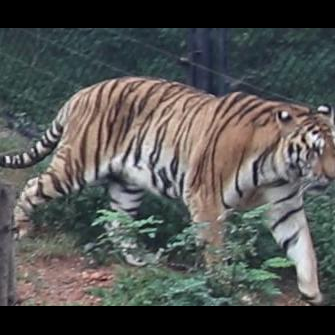

In [12]:
df = dataset.contrastive_sampler.ds

sample = dataset[1]
img = transforms.ToPILImage()(sample[1][0])
img.show()

## General statistics

In [18]:
# make table
def dict_to_latex_table(data):
    # Begin the LaTeX table
    latex_str = "\\begin{tabular}{|c|c|c|}\n"
    latex_str += "\\hline\n"
    latex_str += "Column 1 & Column 2 & Column 3 \\\\\n"
    latex_str += "\\hline\n"

    # Add the data
    for key, value in data.items():
        if len(value) == 2:
            latex_str += f"{key} & {value[0]} & {value[1]} \\\\\n"
            latex_str += "\\hline\n"

    # End the LaTeX table
    latex_str += "\\end{tabular}"

    return latex_str


datasets = df["origin"].unique()
data = {}
for dataset in datasets:
    data[dataset] = [len(df[df["origin"] == dataset]["label"].unique()), len(df[df["origin"] == dataset])]

print(dict_to_latex_table(data))
print("\n\n")

\begin{tabular}{|c|c|c|}
\hline
Column 1 & Column 2 & Column 3 \\
\hline
ATRW & 182 & 5415 \\
\hline
BelugaID & 788 & 8559 \\
\hline
CatIndividualImages & 509 & 13021 \\
\hline
CTai & 70 & 4661 \\
\hline
CZoo & 24 & 2109 \\
\hline
CowDataset & 13 & 1485 \\
\hline
Cows2021 & 178 & 8669 \\
\hline
DogFaceNet & 1393 & 8363 \\
\hline
FriesianCattle2015 & 25 & 193 \\
\hline
FriesianCattle2017 & 84 & 935 \\
\hline
GiraffeZebraID & 1142 & 6011 \\
\hline
HappyWhale & 6329 & 41775 \\
\hline
HumpbackWhaleID & 2931 & 13624 \\
\hline
HyenaID2022 & 256 & 3129 \\
\hline
LeopardID2022 & 380 & 6756 \\
\hline
LionData & 94 & 740 \\
\hline
MacaqueFaces & 34 & 6280 \\
\hline
MPDD & 191 & 1657 \\
\hline
NDD20 & 82 & 2657 \\
\hline
OpenCows2020 & 46 & 4736 \\
\hline
SealID & 57 & 2080 \\
\hline
SeaStarReID2023 & 95 & 2187 \\
\hline
SeaTurtleID2022 & 437 & 8728 \\
\hline
SeaTurtleIDHeads & 398 & 7580 \\
\hline
StripeSpotter & 44 & 819 \\
\hline
WhaleSharkID & 512 & 7662 \\
\hline
ZindiTurtleRecall & 2251 & 1

### ... per Dataset

In [20]:
print(df["origin"].nunique())
print(df["label"].nunique())
print(len(df))

28
18674
183947


In [13]:
import os

base_dir = "/workspaces/gorillatracker/data/WildlifeReID-10k/data"

img_sizes = []
# df = df[df["origin"] == "MacaqueFaces"].copy()

for row in df.itertuples():
    if row.origin != "SPACGorillas2023":
        path = os.path.join(base_dir, row.path)
    else:
        path = row.path

    img = Image.open(path)
    img_sizes.append(img.size)

len(img_sizes)

183947

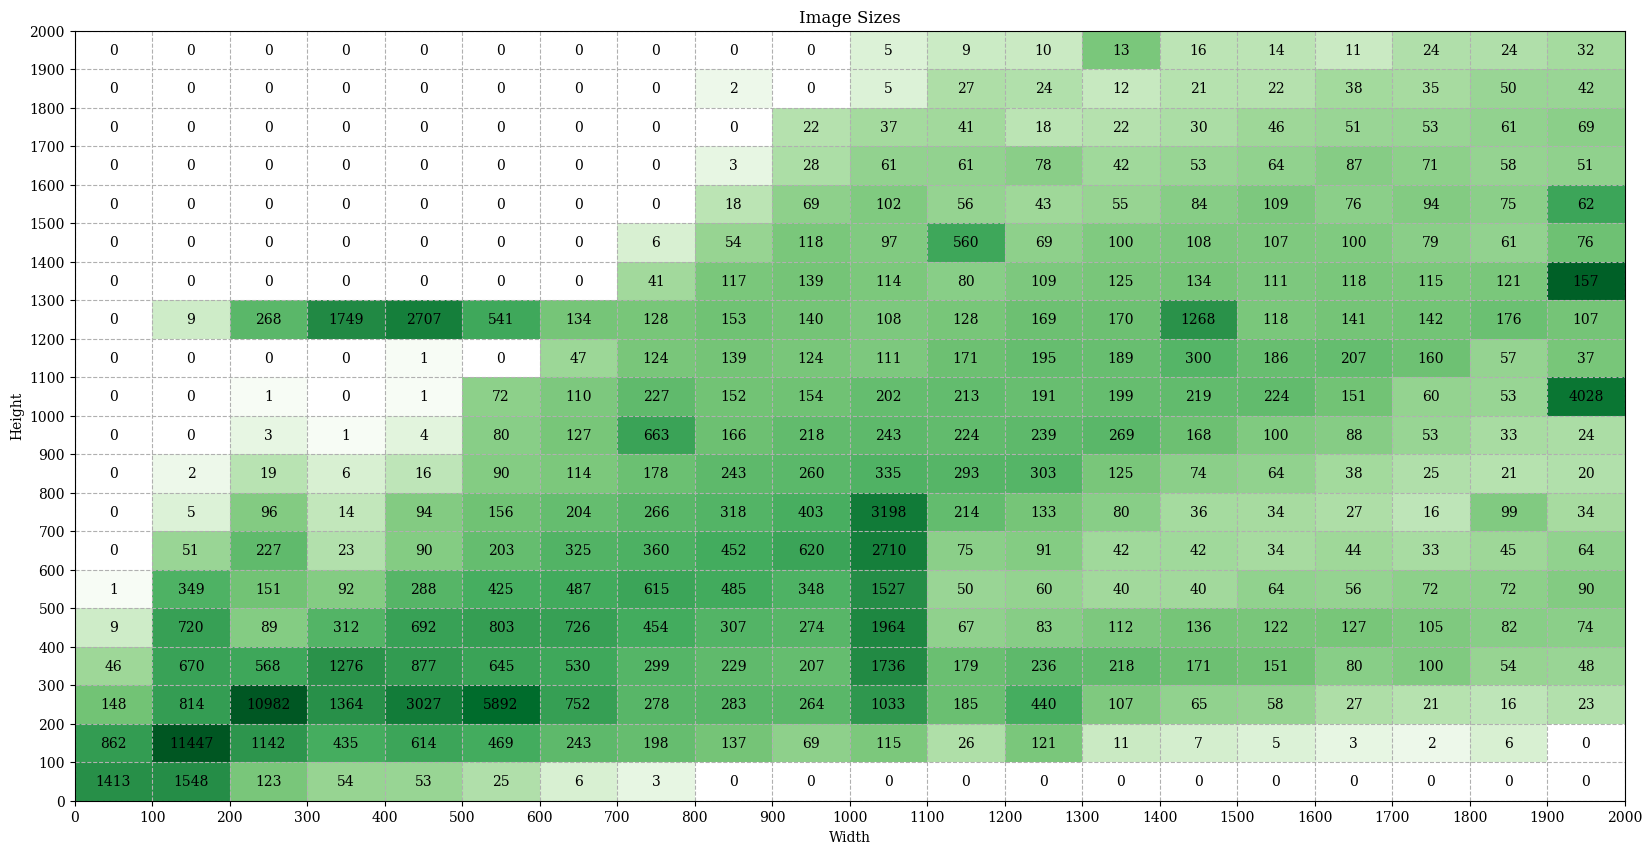

In [17]:
# make a matrix histogram of the image sizes (width x height)
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 10))
amounts_x, amounts_y = [x[0] for x in img_sizes], [x[1] for x in img_sizes]
norm = LogNorm(vmax=20000)
plt.hist2d(amounts_x, amounts_y, bins=range(0, 2100, 100), cmap="Greens", norm=norm)
for i in range(0, 2000, 100):
    for j in range(0, 2000, 100):
        plt.text(
            i + 50,
            j + 50,
            f"{len([1 for x in img_sizes if i <= x[0] < i+100 and j <= x[1] < j+100])}",
            color="black",
            ha="center",
            va="center",
        )
plt.xlabel("Width")
plt.ylabel("Height")
plt.xticks(range(0, 2100, 100))
plt.yticks(range(0, 2100, 100))
plt.title("Image Sizes")
# plt.colorbar()
plt.grid(True, which="both", linestyle="--")
# plt.savefig("plots/spac/bodies_image_sizes.pdf", bbox_inches="tight")
plt.show()

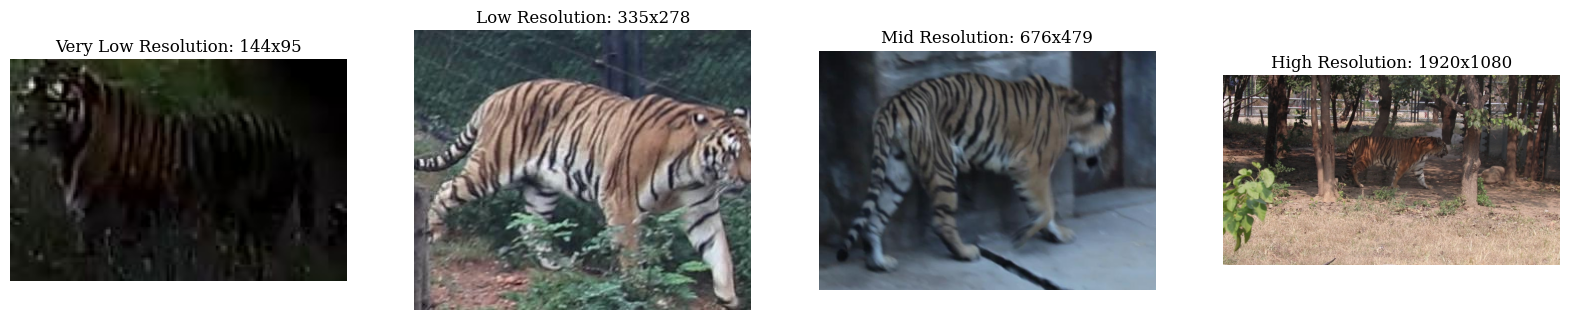

In [19]:
very_low_res = [x for x in img_sizes if x[0] < 200 and x[1] < 200][0]
low_res = [x for x in img_sizes if 200 <= x[0] < 400 and 200 <= x[1] < 400][0]
mid_res = [x for x in img_sizes if 400 <= x[0] < 700 and 400 <= x[1] < 700][0]
high_res = [x for x in img_sizes if x[0] > 800 and x[1] > 800][1]


def get_img(index):
    if df.iloc[index]["origin"] != "SPACGorillas2023":
        return Image.open(os.path.join(base_dir, df.iloc[index]["path"]))
    else:
        return Image.open(df.iloc[index]["path"])


plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
img = get_img(img_sizes.index(very_low_res))
plt.imshow(img)
plt.title(f"Very Low Resolution: {very_low_res[0]}x{very_low_res[1]}")
plt.axis("off")
plt.subplot(1, 4, 2)
img = get_img(img_sizes.index(low_res))
plt.imshow(img)
plt.title(f"Low Resolution: {low_res[0]}x{low_res[1]}")
plt.axis("off")
plt.subplot(1, 4, 3)
img = get_img(img_sizes.index(mid_res))
plt.imshow(img)
plt.title(f"Mid Resolution: {mid_res[0]}x{mid_res[1]}")
plt.axis("off")
plt.subplot(1, 4, 4)
img = get_img(img_sizes.index(high_res))
plt.imshow(img)
plt.title(f"High Resolution: {high_res[0]}x{high_res[1]}")
plt.axis("off")

# plt.savefig("plots/spac/body_resolution_samples.pdf", bbox_inches="tight")
plt.show()

### Get 4 random dataset faces

In [ ]:
macaque_faces = df[df["origin"] == "MacaqueFaces"].sample(4)
plt.figure(figsize=(20, 5))

counter = 0
for i, row in macaque_faces.iterrows():
    plt.subplot(1, 4, counter + 1)
    img = get_img(i)
    plt.imshow(img)
    plt.title(row["identity"])
    plt.axis("off")
    counter += 1

plt.savefig("plots/primate/macaque_faces_samples.pdf", bbox_inches="tight")

In [ ]:
czoo_faces = df[df["origin"] == "CZoo"].sample(4)
plt.figure(figsize=(20, 5))

counter = 0
for i, row in czoo_faces.iterrows():
    plt.subplot(1, 4, counter + 1)
    img = get_img(i)
    plt.imshow(img)
    plt.title(row["identity"])
    plt.axis("off")
    counter += 1

plt.savefig("plots/primate/czoo_faces_samples.pdf", bbox_inches="tight")

In [ ]:
ctai_faces = df[df["origin"] == "CTai"].sample(4)
plt.figure(figsize=(20, 5))

counter = 0
for i, row in ctai_faces.iterrows():
    plt.subplot(1, 4, counter + 1)
    img = get_img(i)
    plt.imshow(img)
    plt.title(row["identity"])
    plt.axis("off")
    counter += 1

plt.savefig("plots/primate/ctai_faces_samples.pdf", bbox_inches="tight")

### Show some stats for all datasets

In [ ]:
# origin = "MacaqueFaces"

# df_stats = df[df["origin"] == origin].copy()

num_images = len(df)
num_individuals = df["label"].nunique()
print(f"Number of images: {num_images}")
print(f"Number of individuals: {num_individuals}")